In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: CIZIUTE, UGNE LAIMA (1495186)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I chose to go for SGD because it performed much better than RMSprop or Adam. Multiple hidden layers helped to converge to better results, because they generilize better, more than 3 didn't seem to make a positive difference. It seems like it reaches optimal result at 32 epoch and then starts overfitting, but if we added more epochs the val_accuracy could still improve, since the val_loss is still flunctuating. (length: 414)



Max val score: 83.97%


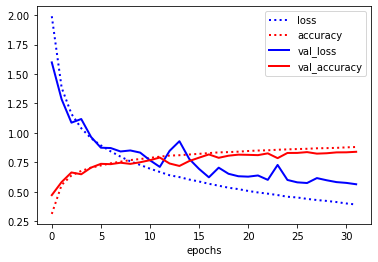

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 3,738,506
Trainable params: 3,738,506
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(3

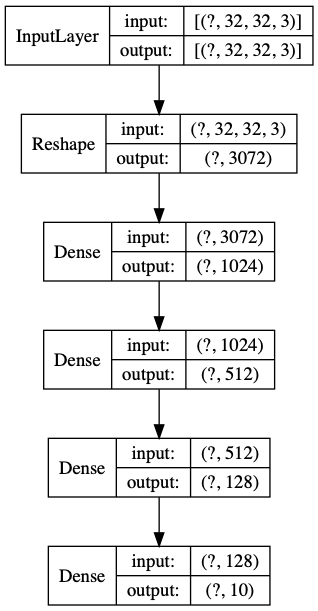

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

The model's val_acuracy as well as val_loss stays pretty much the same since color doesn't change the digit but it does compute faser, because we have less input nodes, so less parameters to learn. The sweet spot of the model is on epoch 30, afterwards it starts overfitting. (length: 276)



Max val score: 83.60%


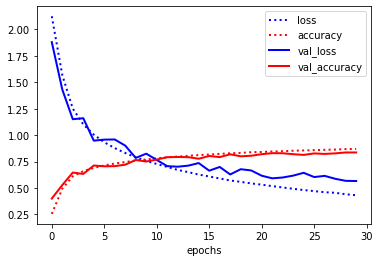

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1290      
Total params: 1,641,354
Trainable params: 1,641,354
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Dropout and L1 regularizer decrease accuracy. It achieves the best accuracy with l2 regularizer in the last hidden layer, more regulirizers don't help. Higher learning rate helps to converge faster to better results and decay helps to regularize the learning rate so that in the later epochs we wouldn't miss the sweet spot. The best results are reached at epoch 26, but if we added more epochs the val_accuracy could still improve, since the val_loss is still flunctuating.. (length: 476)



Max val score: 84.81%


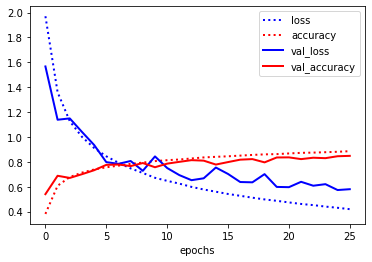

def build_model_1_3():
    model = models.Sequential()
    sgd = optimizers.SGD(lr=0.05, decay=1e-5)
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Using multiple convolutional hidden layers allows for better accuracy and smaller loss, because multiple different filters could be recognized. MaxPooling allows to summarize the most activated features. BatchNormalization increases accuracy and allows for faster converge, because it normalizes each batch by both mean and variance reference. Dropout helps to generilize better, less overfitting, nodes are forced to learn new patterns. Padding helps to not lose information while applying convolutions. After trying out multiple combinations of Dropout, BatchNormalization and Conv2D layers this seemed to produce the best results. The best accuracy is ahieved around epoch 26, at that point the model stabilizes and afterwards it starts overfitting. (length: 753)



Max val score: 95.60%


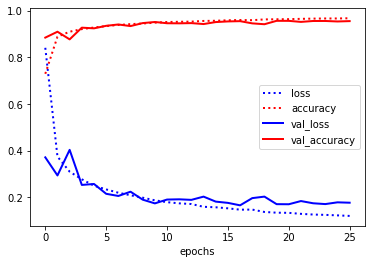

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 48)        480       
_________________________________________________________________
batch_normalization_27 (Batc (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        27712     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 128)      

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
   

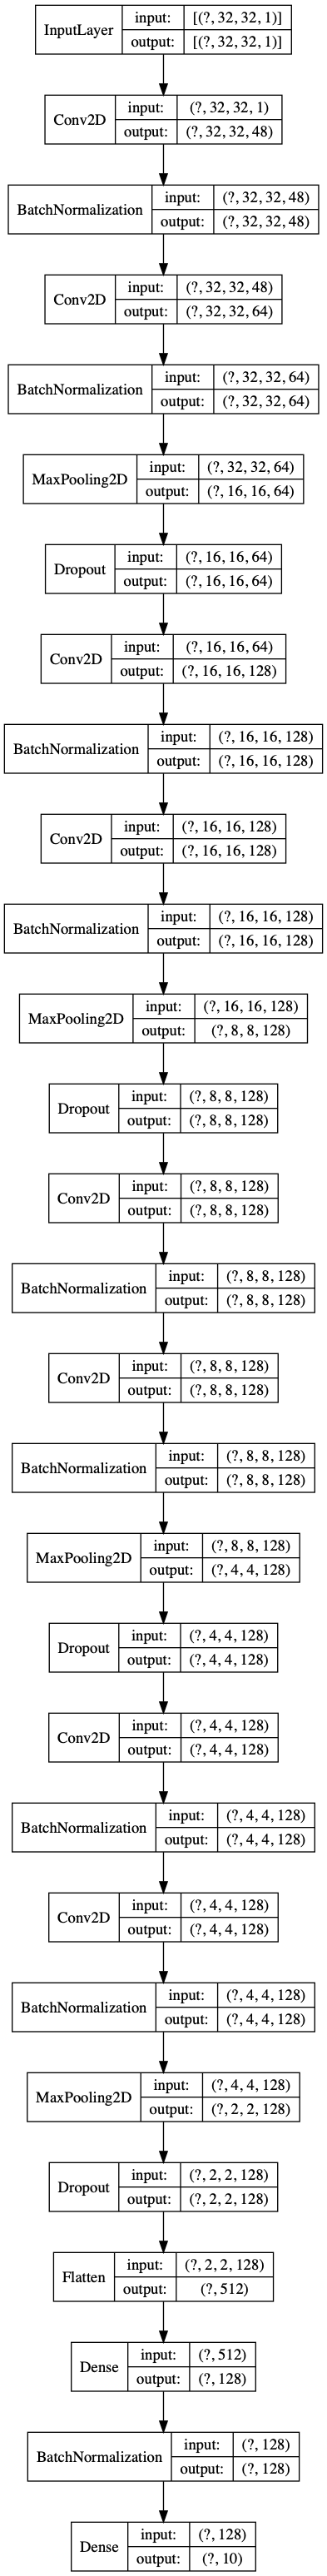

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Zoom increases val_accuracy because the digit in the image is always centered which means that zoom can help to focus even better on the digit. Augmentation allowed the model to learn more from the data at the cost of a longer training time. The best results are achieved on epoch 55, later starts overfitting. Rotation, shift and sheer didn't have any significant impact when applied in small doses. Flipping lowered the accuracy because a flipped number can become a totally different number. (length: 495)



Max val score: 96.27%


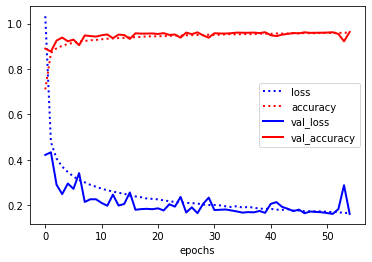


    train_datagen = ImageDataGenerator(zoom_range=0.3)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

From the confusion matrix we can see that that nr. 7 is often confused with nr. 1, which makes sense as these numbers are very similar, but the opposite is a more rare case. Nr. 5 is often confused with nr. 3, which is interesting as these numbers are quite different. Nr. 1 seems to be often confused with many other numbers. As nr. 1 is often missclassified we analyze more in depth what is happening. We noticed that sometimes the true labeled attached to the picture is wrong. Also, very often the picture is centered not around the number in the label but around a different number, while the nr. from the label is on a side. Sometimes the image quality is so low that it's hard to tell with a plain eye what number is supposed to be there. (length: 746)

Test score: 0.96%


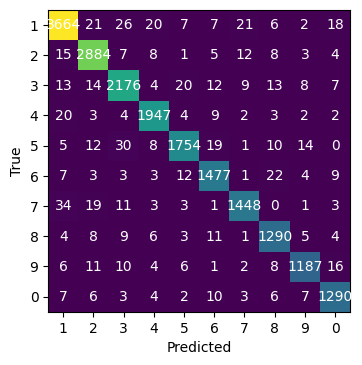

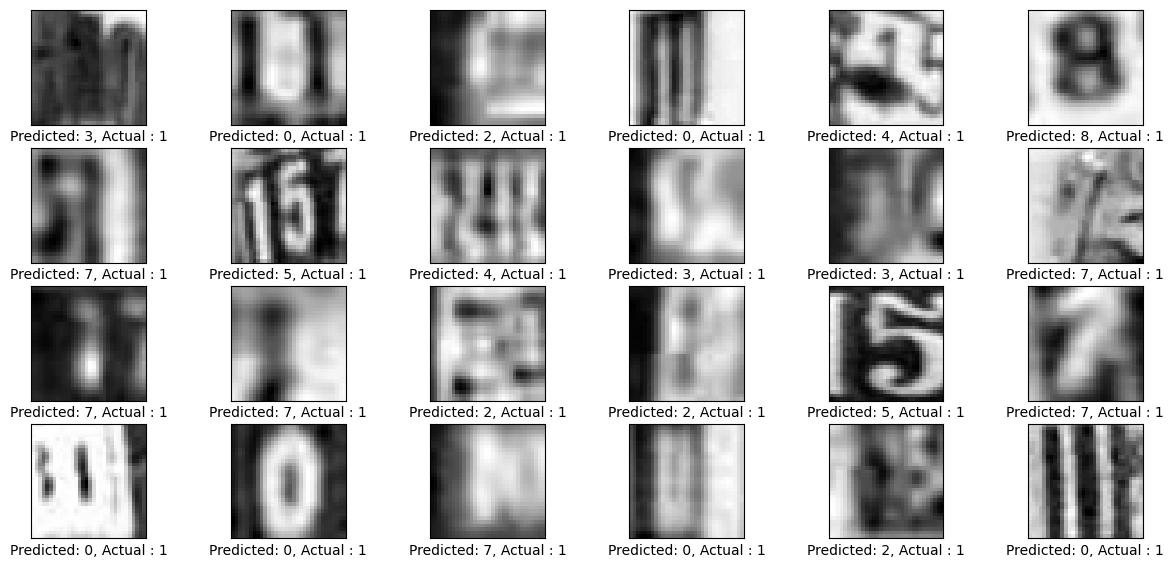

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In the first conv. layer only some filters get activated recognizing the shape of a nr. 8. The picture did not have certain data to activate other filters. In layer 3 the filters become more abstract enhancing different parts of the number. Afterwards the filters focus on very specific parts of the picture, but the nr. 8 can still be recognized where the filter focuses on the number's contour. After MaxPooling has been applied twice the conv. layers produce filters that become unrecognizable. (length: 498)



Prediction of the first example: 8


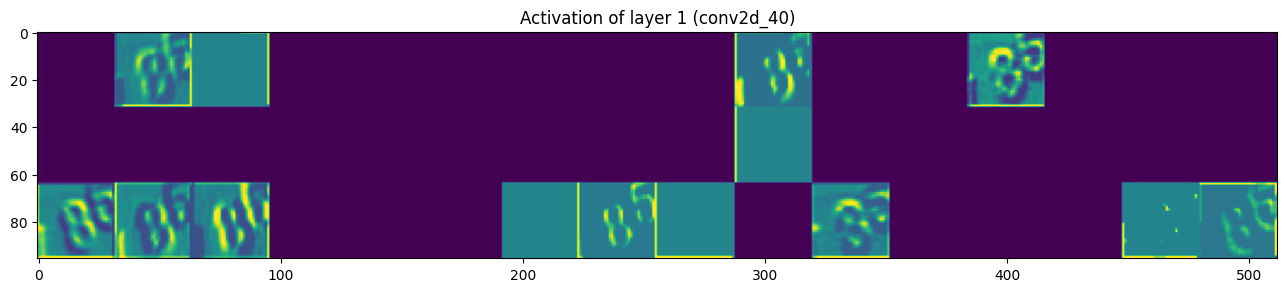

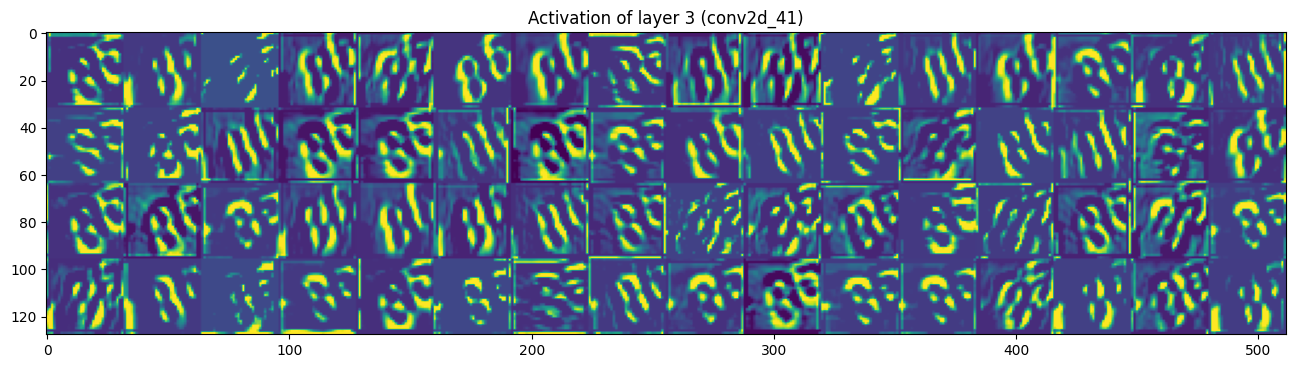

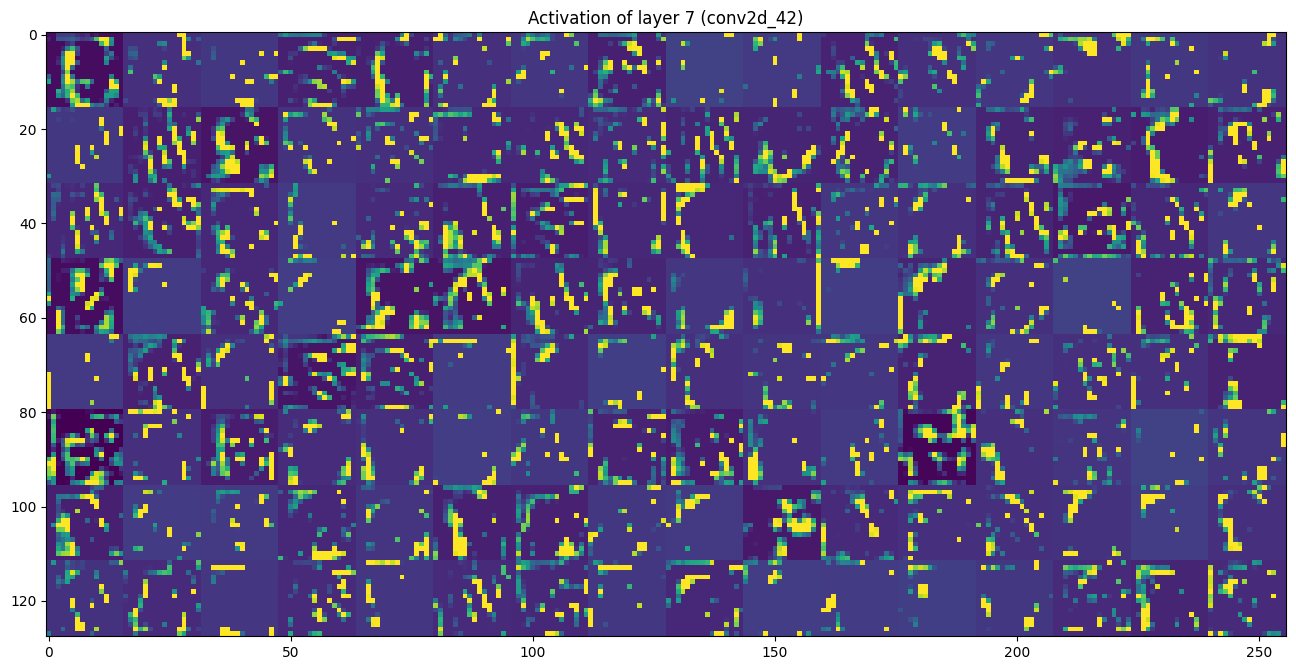

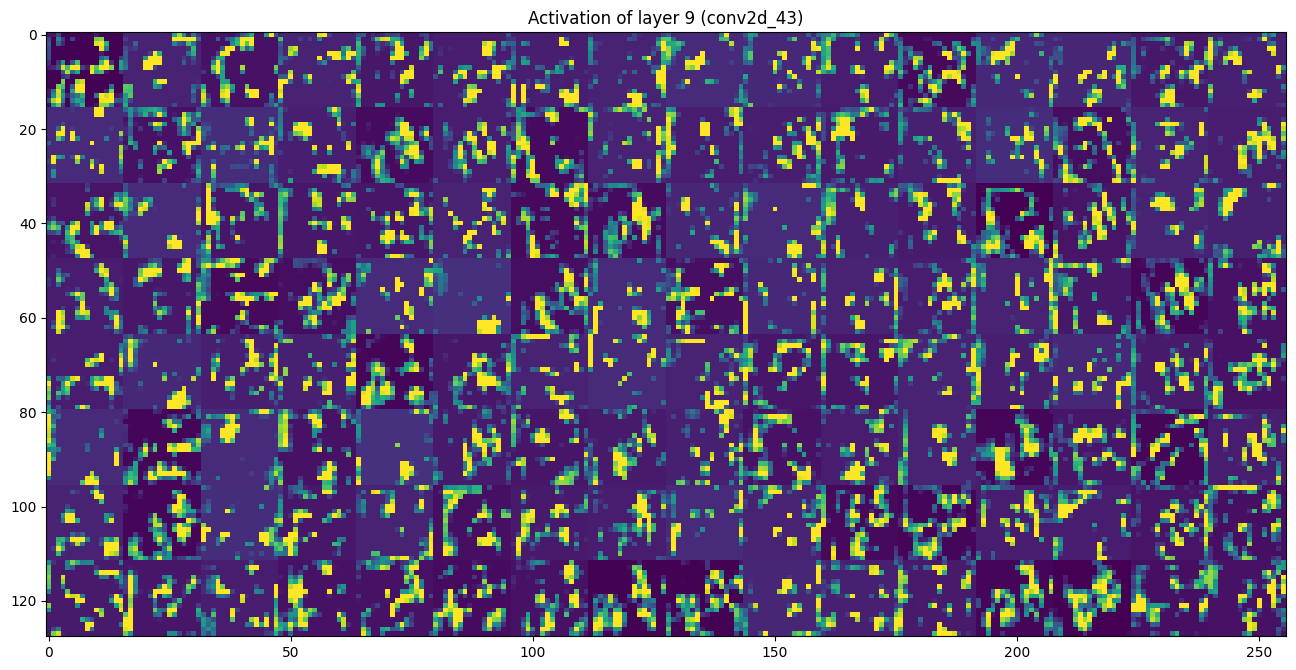

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

def plot_3_3():
    X_test_grey = rgb2gray(X_test)
    img_tensor = X_test_grey[0]
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    model = load_model_from_file(base_dir, "model_2_2")
    last_conv_layer_name  = 'conv2d_47'
    heatmap = get_activation_map(img_tensor, model, last_conv_layer_name)
    plot_superimposed_activation_map(X_test[0], heatmap)



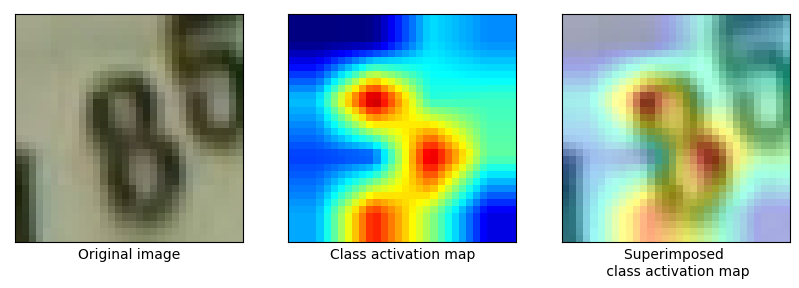

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

The base VGG16 model performs quite badly. The more layers get unfrozen, the better results are produced, but if all layers get unfrozen then there is no point of haivng a pretrained model. Time and accuracy wise I chose to unfreeze 2 blocks of conv. layers and added padding to them to prevent loss of some information. Small learning rate with a decay allowed me to steadily but fast achieve good results. We are able to stop the training at 4th epoch. (length: 455)



Max val score: 89.60%


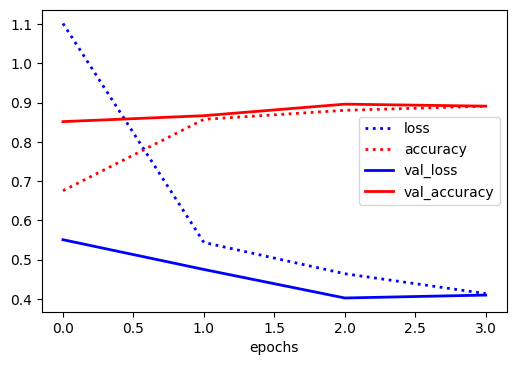

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 14,880,202
Trainable params: 13,144,714
Non-trainable params: 1,735,488
__________________________________

def build_model_4_1():
  conv_base = VGG16(weights='imagenet', 
                include_top=False,
                input_shape=(32, 32, 3))
  conv_base.trainable = True
  set_trainable = False
  for layer in conv_base.layers:
      if layer.name == 'block4_conv1':
          set_trainable = True
      if set_trainable:
          layer.trainable = True
          layer.padding = 'same'
      else:
          layer.trainable = False
    
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model



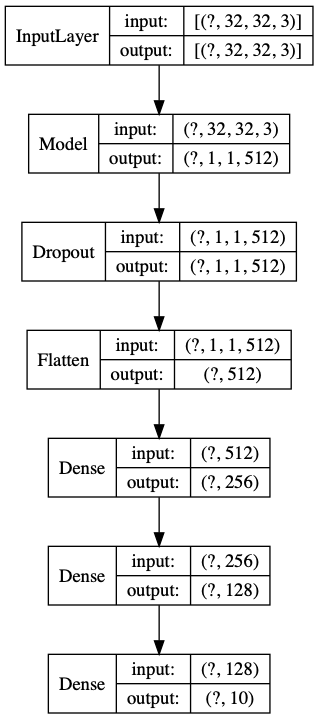

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

Looking at the cumulative explained_variance_ratio sum provided by PCA on validation set I picked 12 components as they explain 99% of the variance. Using GridSearch I determined that SVC with C=40 and gamma=0.0003 provides the best accuracy on the validation set, so subsequently I applied it on the train and test sets and the accuracy is as good ~91%. Sadly, it didn't beat my best model which has around 96% accuracy, but considering that it is a partially pretrained model, it's quite good. (length: 496)

Pipeline(steps=[('pca', PCA(n_components=12)),
                ('svc', SVC(C=40, gamma=0.0003))])
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  model = load_model_from_file(base_dir, "model_4_1")
  conv_layer = model.get_layer('vgg16')

  store_embedding(np.squeeze(conv_layer.predict(X_train)), 'train')
  store_embedding(np.squeeze(conv_layer.predict(X_test)), 'test')

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' 

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 19.17 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
